# Simple Azure ML tutorial using cats vs dogs dataset

In this notebook-based tutorial, we will prepare our dogs-vs-cats dataset and train a binary classification model.
This tutorial includes data-preparation and training a model using Auto ML.

We followed this Azure ML [tutorial](https://github.com/Azure/azureml-examples/blob/main/sdk/python/jobs/automl-standalone-jobs/automl-image-classification-multiclass-task-fridge-items/automl-image-classification-multiclass-task-fridge-items.ipynb).

## Set Up
We first need to install the azure-ai-ml and azureml Python packages.

In [ ]:
!pip install azure-ai-ml

In [ ]:
!pip install mldesigner

In [ ]:
!pip install azureml

In [2]:
# Import required libraries
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient

from azure.ai.ml.automl import SearchSpace, ClassificationPrimaryMetrics
from azure.ai.ml.sweep import (
    Choice,
    Choice,
    Uniform,
    BanditPolicy,
)

from azure.ai.ml import automl

## Connect to workspace

In [3]:
# Handle to the workspace
from azure.ai.ml import MLClient, Input

# Authentication package
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [4]:
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="SUBSCRIPTION_ID",
    resource_group_name="RESOURCE_GROUP_NAME",
    workspace_name="WORKSPACE_NAME",
)

## Set up necessary variables

There are some variables used in this tutorial. You can customize these
variables as you want.

In [1]:
import os

experiment_name = "cats_vs_dogs_without_pipeline"
compute_name = "gpu-cluster"

data_root ='../datasets/dogs_vs_cats_small'
train_dataset_dir = os.path.join(data_root, 'train')
test_dataset_dir = os.path.join(data_root, 'test')

train_cats_dir = os.path.join(train_dataset_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dataset_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(test_dataset_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(test_dataset_dir, 'dogs')  # directory with our validation dog pictures


num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val


print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)
print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 102
total training dog images: 100
total validation cat images: 52
total validation dog images: 50
--
Total training images: 202
Total validation images: 102


This is a sample image from this dataset:

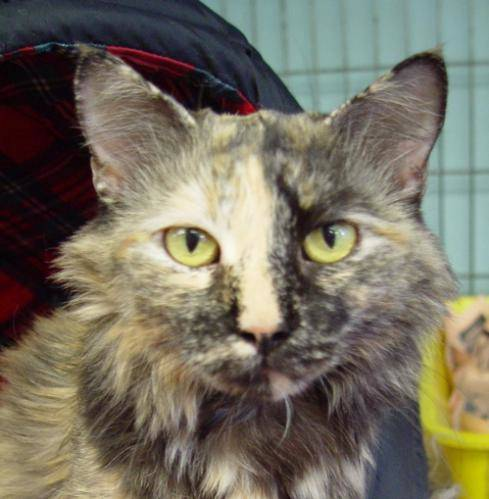

In [2]:
from IPython.display import Image
sample_image = os.path.join(test_dataset_dir, "cats", "cat.10.jpg")
Image(filename=sample_image)

## Upload the images to Datastore through an AML Data asset (URI Folder)

In order to use the data for training in Azure ML, we upload it to our default Azure Blob Storage of our  Azure ML Workspace.

[Check this notebook for AML data asset example](../../../assets/data/data.ipynb)

In [ ]:
# Uploading image files by creating a 'data asset URI FOLDER':

from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml import Input

my_train_data = Data(
    path=train_dataset_dir,
    type=AssetTypes.URI_FOLDER,
    description="200 images of cats and dogs for training purposes",
    name="dogs_vs_cats_train",
)

my_test_data = Data(
    path=test_dataset_dir,
    type=AssetTypes.URI_FOLDER,
    description="100 images of cats and dogs for validation purposes",
    name="dogs_vs_cats_test",
)

uri_folder_train_data_asset = ml_client.data.create_or_update(my_train_data)
uri_folder_test_data_asset = ml_client.data.create_or_update(my_test_data)

print(uri_folder_test_data_asset)
print("")
print("Path to folder in Blob Storage:")
print(uri_folder_test_data_asset.path)

## Convert the downloaded data to JSONL

In our example, the dogs-vs-cats dataset is stored in a directory. There are two different folders inside:

- /train
    - dogs
    - cats
- /test
    - dogs
    - cats

This is a common data format for multiclass image classification. Each folder title corresponds to the image label for the images contained inside. For documentation on preparing the datasets beyond this notebook, please refer to the [documentation on how to prepare datasets](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-prepare-datasets-for-automl-images).

In order to use this data to create an AzureML MLTable, we first need to convert it to the required JSONL format. The following script is creating two `.jsonl` files (one for training and one for validation) in the corresponding MLTable folder. For further details on jsonl file used for image classification task in automated ml, please refer to the [data schema documentation for multi-class image classification task](https://learn.microsoft.com/en-us/azure/machine-learning/reference-automl-images-schema#image-classification-binarymulti-class).

In [8]:
import json
import os


# We'll copy each JSONL file within its related MLTable folder
training_mltable_path = os.path.join("json_dataset", "training-mltable-folder")
validation_mltable_path = os.path.join("json_dataset", "validation-mltable-folder")

# First, let's create the folders if they don't exist
os.makedirs(training_mltable_path, exist_ok=True)
os.makedirs(validation_mltable_path, exist_ok=True)

train_validation_ratio = 5

# Path to the training and validation files
train_annotations_file = os.path.join(training_mltable_path, "train_annotations.jsonl")
validation_annotations_file = os.path.join(
    validation_mltable_path, "validation_annotations.jsonl"
)

# Baseline of json line dictionary
json_line_train_sample = {
    "image_url": uri_folder_train_data_asset.path,
    "label": "",
}

json_line_test_sample = {
    "image_url": uri_folder_test_data_asset.path,
    "label": "",
}

index = 0
# Scan each sub directary and generate a jsonl line per image, distributed on train and valid JSONL files

with open(train_annotations_file, "w") as train_f:
    for class_name in os.listdir(train_dataset_dir):
        sub_dir = os.path.join(train_dataset_dir, class_name)
        if not os.path.isdir(sub_dir):
            continue

        # Scan each sub directary
        print(f"Parsing {sub_dir}")
        for image in os.listdir(sub_dir):
            json_line = dict(json_line_train_sample)
            json_line["image_url"] += f"{class_name}/{image}"
            json_line["label"] = class_name[:-1]
            
            train_f.write(json.dumps(json_line) + "\n")
            index += 1

with open(validation_annotations_file, "w") as validation_f:
    for class_name in os.listdir(test_dataset_dir):
        sub_dir = os.path.join(test_dataset_dir, class_name)
        if not os.path.isdir(sub_dir):
            continue

        # Scan each sub directary
        print(f"Parsing {sub_dir}")
        for image in os.listdir(sub_dir):
            json_line = dict(json_line_test_sample)
            json_line["image_url"] += f"{class_name}/{image}"
            json_line["label"] = class_name[:-1]
            
            validation_f.write(json.dumps(json_line) + "\n")
            index += 1

Parsing raw_dataset/train/cats
Parsing raw_dataset/train/dogs
Parsing raw_dataset/test/cats
Parsing raw_dataset/test/dogs


## Create MLTable data input

Create MLTable data input using the jsonl files created above.

For documentation on creating your own MLTable assets for jobs beyond this notebook, please refer to below resources
- [MLTable YAML Schema](https://learn.microsoft.com/en-us/azure/machine-learning/reference-yaml-mltable) - covers how to write MLTable YAML, which is required for each MLTable asset.
- [Create MLTable data asset](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-data-assets?tabs=Python-SDK#create-a-mltable-data-asset) - covers how to create MLTable data asset. 

In [9]:
def create_ml_table_file(filename):
    """Create ML Table definition"""

    return (
        "paths:\n"
        "  - file: ./{0}\n"
        "transformations:\n"
        "  - read_json_lines:\n"
        "        encoding: utf8\n"
        "        invalid_lines: error\n"
        "        include_path_column: false\n"
        "  - convert_column_types:\n"
        "      - columns: image_url\n"
        "        column_type: stream_info"
    ).format(filename)


def save_ml_table_file(output_path, mltable_file_contents):
    with open(os.path.join(output_path, "MLTable"), "w") as f:
        f.write(mltable_file_contents)


# Create and save train mltable
train_mltable_file_contents = create_ml_table_file(
    os.path.basename(train_annotations_file)
)
save_ml_table_file(training_mltable_path, train_mltable_file_contents)

# Create and save validation mltable
validation_mltable_file_contents = create_ml_table_file(
    os.path.basename(validation_annotations_file)
)
save_ml_table_file(validation_mltable_path, validation_mltable_file_contents)

In [10]:
# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = Input(type=AssetTypes.MLTABLE, path=training_mltable_path)

# Validation MLTable defined locally, with local data to be uploaded
my_validation_data_input = Input(type=AssetTypes.MLTABLE, path=validation_mltable_path)

# WITH REMOTE PATH: If available already in the cloud/workspace-blob-store
# my_training_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/train")
# my_validation_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/valid")

## Configure and run the AutoML for Images Classification-MultiClass training job
First, you need to create a gpu-cluster. In this example the gpu-cluster is: *Standard_NC24ads_A100_v4 (24 cores, 220 GB RAM, 64 GB disk)*

In [12]:
# Create the AutoML job with the related factory-function.

image_classification_job = automl.image_classification(
    compute=compute_name,
    # name="dpv2-image-classification-job-02",
    experiment_name=experiment_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    primary_metric="accuracy",
    tags={"my_custom_tag": "My custom value"},
)

image_classification_job.set_limits(
    max_trials=1,
    max_concurrent_trials=1,
)

### Submitting an AutoML job for Computer Vision tasks
Once you've configured your job, you can submit it as a job in the workspace in order to train a vision model using your training dataset.

In [13]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    image_classification_job
)  # submit the job to the backend

print(f"Created job: {returned_job}")

Created job: compute: azureml:gpu-cluster
creation_context:
  created_at: '2023-05-23T13:06:17.259918+00:00'
  created_by: Hadi Ansari
  created_by_type: User
display_name: neat_kale_13t8nnnvch
experiment_name: cats_vs_dogs
id: azureml:/subscriptions/c6c6e76b-a64b-4a2e-87e4-4122626f39c7/resourceGroups/exjobb-t2304-11614/providers/Microsoft.MachineLearningServices/workspaces/ritko75_exjobb/jobs/neat_kale_13t8nnnvch
limits:
  max_concurrent_trials: 1
  max_trials: 1
  timeout_minutes: 10080
log_verbosity: info
name: neat_kale_13t8nnnvch
outputs: {}
primary_metric: accuracy
properties: {}
resources:
  instance_count: 1
  shm_size: 2g
services:
  Studio:
    endpoint: https://ml.azure.com/runs/neat_kale_13t8nnnvch?wsid=/subscriptions/c6c6e76b-a64b-4a2e-87e4-4122626f39c7/resourcegroups/exjobb-t2304-11614/workspaces/ritko75_exjobb&tid=913f18ec-7f26-4c5f-a816-784fe9a58edd
    job_service_type: Studio
  Tracking:
    endpoint: azureml://swedencentral.api.azureml.ms/mlflow/v1.0/subscriptions/c6

In [14]:
ml_client.jobs.stream(returned_job.name)

RunId: neat_kale_13t8nnnvch
Web View: https://ml.azure.com/runs/neat_kale_13t8nnnvch?wsid=/subscriptions/c6c6e76b-a64b-4a2e-87e4-4122626f39c7/resourcegroups/exjobb-t2304-11614/workspaces/ritko75_exjobb

Execution Summary
RunId: neat_kale_13t8nnnvch
Web View: https://ml.azure.com/runs/neat_kale_13t8nnnvch?wsid=/subscriptions/c6c6e76b-a64b-4a2e-87e4-4122626f39c7/resourcegroups/exjobb-t2304-11614/workspaces/ritko75_exjobb



In [15]:
from mlflow.tracking.client import MlflowClient

# Initialize MLFlow client
mlflow_client = MlflowClient()

### Get the AutoML parent Job

In [16]:
job_name = returned_job.name

# Example if providing an specific Job name/ID
# job_name = "salmon_camel_5sdf05xvb3"

# Get the parent run
mlflow_parent_run = mlflow_client.get_run(job_name)

print("Parent Run: ")
print(mlflow_parent_run)

Parent Run: 
<Run: data=<RunData: metrics={'AUC_binary': 1.0,
 'AUC_macro': 1.0,
 'AUC_micro': 1.0,
 'AUC_weighted': 1.0,
 'accuracy': 1.0,
 'accuracy_train': 0.97059,
 'average_precision_score_binary': 1.0,
 'average_precision_score_macro': 1.0,
 'average_precision_score_micro': 1.0,
 'average_precision_score_weighted': 1.0,
 'f1_score_binary': 1.0,
 'f1_score_macro': 1.0,
 'f1_score_micro': 1.0,
 'f1_score_weighted': 1.0,
 'log_loss': 4e-05,
 'log_loss_train': 0.01816,
 'precision_score_binary': 1.0,
 'precision_score_macro': 1.0,
 'precision_score_micro': 1.0,
 'precision_score_weighted': 1.0,
 'recall_score_binary': 1.0,
 'recall_score_macro': 1.0,
 'recall_score_micro': 1.0,
 'recall_score_weighted': 1.0}, params={}, tags={'automl_best_child_run_id': 'neat_kale_13t8nnnvch_HD_0',
 'fit_time_000': 'NaN',
 'is_gpu': 'True',
 'iteration_000': '0',
 'mlflow.rootRunId': 'neat_kale_13t8nnnvch',
 'mlflow.runName': 'neat_kale_13t8nnnvch',
 'mlflow.user': 'Hadi Ansari',
 'model_explain_run'

### Get the AutoML best child run

In [17]:
# Get the best model's child run

best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print(f"Found best child run id: {best_child_run_id}")

best_run = mlflow_client.get_run(best_child_run_id)

print("Best child run: ")
print(best_run)

Found best child run id: neat_kale_13t8nnnvch_HD_0
Best child run: 
<Run: data=<RunData: metrics={'AUC_binary': 1.0,
 'AUC_macro': 1.0,
 'AUC_micro': 1.0,
 'AUC_weighted': 1.0,
 'accuracy': 1.0,
 'accuracy_train': 0.97059,
 'average_precision_score_binary': 1.0,
 'average_precision_score_macro': 1.0,
 'average_precision_score_micro': 1.0,
 'average_precision_score_weighted': 1.0,
 'f1_score_binary': 1.0,
 'f1_score_macro': 1.0,
 'f1_score_micro': 1.0,
 'f1_score_weighted': 1.0,
 'log_loss': 4e-05,
 'log_loss_train': 0.01816,
 'precision_score_binary': 1.0,
 'precision_score_macro': 1.0,
 'precision_score_micro': 1.0,
 'precision_score_weighted': 1.0,
 'recall_score_binary': 1.0,
 'recall_score_macro': 1.0,
 'recall_score_micro': 1.0,
 'recall_score_weighted': 1.0}, params={}, tags={'hyperparameters': '{"ignored_argument": 0}',
 'mlflow.parentRunId': 'neat_kale_13t8nnnvch_HD',
 'mlflow.rootRunId': 'neat_kale_13t8nnnvch',
 'mlflow.runName': 'jovial_avocado_p5hy73gp',
 'mlflow.source.name

In [27]:
best_run.data.metrics["log_loss_train"]

0.01816

## Get best model run's metrics
Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [22]:
import pandas as pd

metrics = pd.DataFrame(best_run.data.metrics, index=[0]).T
metrics

,0
accuracy_train,0.97000
log_loss_train,0.09435
log_loss,0.00150
recall_score_binary,1.00000
AUC_binary,1.00000
f1_score_macro,1.00000
precision_score_weighted,1.00000
average_precision_score_macro,1.00000
precision_score_binary,1.00000
accuracy,1.00000


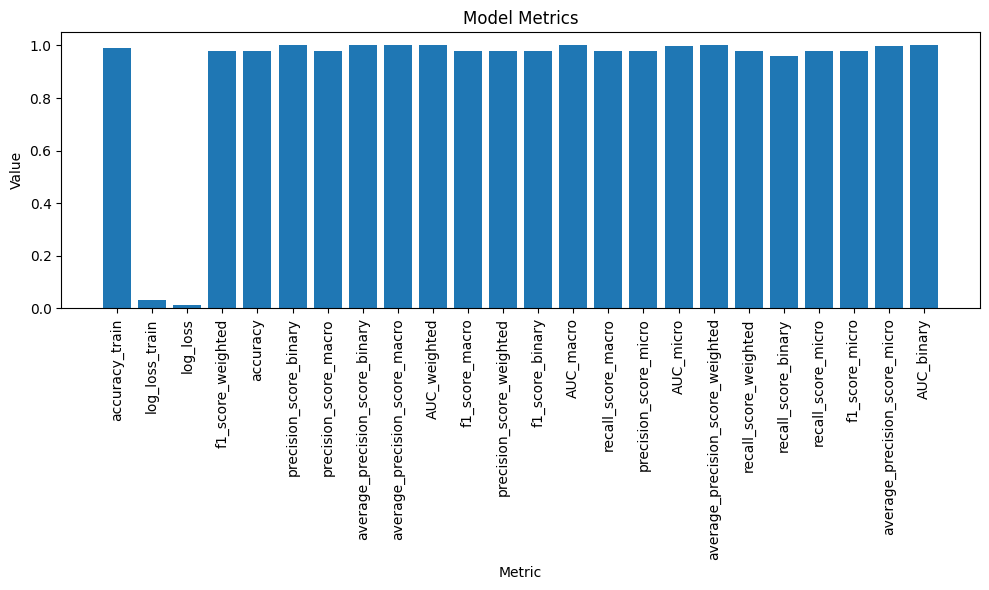

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

metrics = pd.DataFrame({
    'Metric': [
        'accuracy_train', 'log_loss_train', 'log_loss', 'f1_score_weighted',
        'accuracy', 'precision_score_binary', 'precision_score_macro',
        'average_precision_score_binary', 'average_precision_score_macro',
        'AUC_weighted', 'f1_score_macro', 'precision_score_weighted',
        'f1_score_binary', 'AUC_macro', 'recall_score_macro',
        'precision_score_micro', 'AUC_micro', 'average_precision_score_weighted',
        'recall_score_weighted', 'recall_score_binary', 'recall_score_micro',
        'f1_score_micro', 'average_precision_score_micro', 'AUC_binary'
    ],
    'Value': [
        0.99, 0.03232, 0.01497, 0.97999, 0.98, 1.0, 0.98077, 1.0, 1.0, 1.0,
        0.97999, 0.98077, 0.97959, 1.0, 0.98, 0.98, 0.9996, 1.0, 0.98, 0.96,
        0.98, 0.98, 0.99961, 1.0
    ]
})

plt.figure(figsize=(10, 6))
plt.bar(metrics['Metric'], metrics['Value'])
plt.xticks(rotation=90)
plt.ylabel('Value')
plt.xlabel('Metric')
plt.title('Model Metrics')
plt.tight_layout()
plt.show()
